In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage.color import rgb2hed, hed2rgb
import skimage.morphology as morphology
import skimage.segmentation as segmentation
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input/'):
#     print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Histopathologic Cancer Detection using CNNs

## Description of Problem and Data
The problem is asking us to identify metastatic tissue in histopathologic scans of lymph node sections. The data consists of .tif files, which are smaller image patches taken from digital pathology scans. To be able to identify the metastatic tissue, we will use CNNs, which are a great choice for image processing.



## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

loading the data

In [2]:
train = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
train.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [4]:
print("\nLabel Distribution:")
label_counts = train['label'].value_counts()
print(label_counts)


Label Distribution:
label
0    130908
1     89117
Name: count, dtype: int64


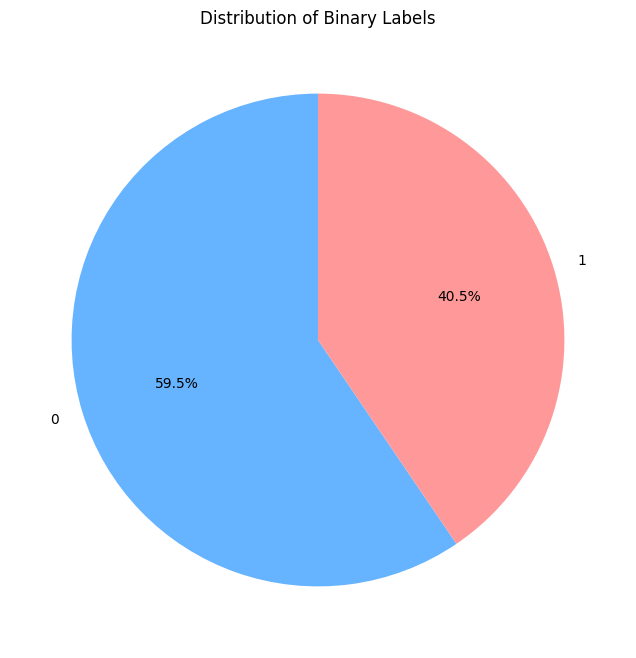

In [5]:

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Distribution of Binary Labels')
plt.show()

Here we see that we are slightly overweight no cancer vs cancer.
Let's create a more sampled dataset.

In [6]:
import pandas as pd
from sklearn.utils import shuffle

# Sample negatives and positives
df_negatives = train.query('label == 0').sample(5000)
df_positives = train.query('label == 1').sample(5000)

# Combine and shuffle
shuffled_train = shuffle(pd.concat([df_negatives, df_positives]).reset_index(drop=True))

shuffled_train.head()

,id,label
8407,7bf008c54fd26d60808b2cbe2be922c469efb10d,1
7710,9cadf7c06db0e2776b2255607be8665108d395bc,1
8644,53d443720f71ca4e028872f67ac9766c80768d2b,1
3421,78c17e79d325283b5f9fd1ebdee5d9d2decaeebf,0
9539,51d0f0108430ea89f428caecd9863eab8fb1802e,1


Now lets visualize an image of this

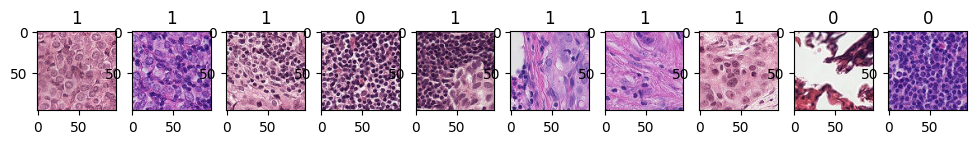

In [7]:
count = 0
img_list = []
label_list = []
for index, row in shuffled_train.iterrows():
    img = Image.open('/kaggle/input/histopathologic-cancer-detection/train/' + row['id']+'.tif')
    img_list.append(img)
    label_list.append(row['label'])
    count +=1
    if count > 9:
        break
        
# Plotting all images in a grid
fig, axes = plt.subplots(1,10,figsize=(12, 12))
axes = axes.flatten()

for i, img in enumerate(img_list):
    axes[i].imshow(img)
    axes[i].set_title(label_list[i])

plt.show()


Now to actually clean the data..., doing some research on histopathologic scans, I see that possible cleaning techniques is noise reduction, so lets do that!

In [8]:
def preprocess_image(id):
  img_path = '/kaggle/input/histopathologic-cancer-detection/train/' + id+'.tif'
  rgb_img = cv2.imread(img_path)
  # Enhance contrast using CLAHE
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  lab = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2LAB)
  l, a, b = cv2.split(lab)
  l1 = clahe.apply(l)
  lab = cv2.merge((l1, a, b))
  rgb_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

  # Noise reduction using Gaussian blur
  rgb_img = cv2.GaussianBlur(rgb_img, (5, 5), 0)

  # Morphological operations for artifact removal
  kernel = np.ones((3, 3), np.uint8)
  rgb_img = cv2.morphologyEx(rgb_img, cv2.MORPH_OPEN, kernel)
#   print(rgb_img.shape)
  return rgb_img


shuffled_train['Processed Image'] = shuffled_train['id'].apply(preprocess_image)
# for index, row in shuffled_train.iterrows():
#     row['Processed Image'] = preprocess_image()
#     arr = np.array(row['Processed Image'])
#     arr = arr.astype(np.uint8)
#     arr = arr.reshape(arr.shape[0], arr.shape[1], 3)
# #     plt.imshow(arr)



In [9]:
shuffled_train.iloc[0]


id                          7bf008c54fd26d60808b2cbe2be922c469efb10d
label                                                              1
Processed Image    [[[162, 137, 188], [162, 137, 188], [150, 123,...
Name: 8407, dtype: object

Now that we have cleaned images, lets stick it in a CNN! Our model architecture should just be stacking conv and pooling layers. 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(36864, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = x.reshape(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

model = CNNModel()

Why I chose the following model structure:

Convolutional Layers: Two layers allow for learning both low-level features (edges, textures) and higher-level features (shapes, patterns) relevant to cell structure.
Max Pooling: Reduces spatial dimensions, making the model more computationally efficient and helping it focus on the most important features.
Increasing Filter Count (32 to 64): Allows the network to learn more complex features as it goes deeper.
Fully Connected Layers: These layers learn to combine the features extracted by the convolutional layers for the final classification.
Output: A single output neuron is used for binary classification (cancerous or not).


Other architectures include fully connected neural networks, but they wouldn't splice the image to capture features. Another choice could be using a defined architecture like YOLO, but that also is a problem because that is object detection, not cellular analysis.


In [11]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

processed_images_np = np.array(shuffled_train['Processed Image'].tolist())
train_dataset = TensorDataset(torch.from_numpy(processed_images_np), torch.tensor(shuffled_train['label']))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for epoch in range(10):
    for images, labels in train_loader:
        images = images.float() / 255.0
        images = images.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(1),labels.float())
        loss.backward()
        optimizer.step()

In [12]:
torch.save(model.state_dict(), 'my_model_weights.pth')

In [13]:
model.load_state_dict(torch.load('my_model_weights.pth'))

def preprocess_image(filename):
  img_path = '/kaggle/input/histopathologic-cancer-detection/test/' + filename
  rgb_img = cv2.imread(img_path)
  # Enhance contrast using CLAHE
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  lab = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2LAB)
  l, a, b = cv2.split(lab)
  l1 = clahe.apply(l)
  lab = cv2.merge((l1, a, b))
  rgb_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

  # Noise reduction using Gaussian blur
  rgb_img = cv2.GaussianBlur(rgb_img, (5, 5), 0)

  # Morphological operations for artifact removal
  kernel = np.ones((3, 3), np.uint8)
  rgb_img = cv2.morphologyEx(rgb_img, cv2.MORPH_OPEN, kernel)
#   print(rgb_img.shape)
  return rgb_img

#length should be 57458
name = []
y_pred = []
model.eval()
count = 0
for dirname, _, filenames in os.walk('/kaggle/input/histopathologic-cancer-detection/test/'):
    for filename in filenames:
        name.append(filename[:-4])
        image = preprocess_image(filename)
        image = torch.from_numpy(image)
        image = image.float() / 255.0
        # Transpose the image to [channels, height, width] format
        image = image.permute(2, 0, 1)
        image = image.unsqueeze(0)
        output = model(image)  # This gives you tensor([[-0.8930]], grad_fn=<AddmmBackward0>)

        probability = torch.sigmoid(output)

        threshold = 0.5
        prediction = (probability > threshold).float()

        label = prediction.item()
        y_pred.append(label)
        count+=1
        torch.cuda.empty_cache()
#         if count > 5000:
#             break
print(count)


57458


In [14]:
print(y_pred[0])
unique_count = len(set(y_pred))
print(unique_count)
print(len(y_pred))



1.0
2
57458


In [15]:
# Create a pandas DataFrame
data = {'id': name, 'label': y_pred}
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('submission.csv', index=False)
